## [Chapter 13] Semantic Search

In [1]:
import sys
sys.path.append('..')
from aips import *

In [2]:
import pandas
import pickle
import json
import tqdm
pandas.set_option('display.max_rows', 1000)

## Load and clean the Outdoors dataset

In [3]:
from ltr.download import download, extract_tgz
import tarfile

dataset = ['https://github.com/ai-powered-search/outdoors/raw/master/outdoors.tgz']
download(dataset, dest='data/')
extract_tgz('data/outdoors.tgz') # Get 'posts.csv', a big CSV file of the stackexchange outdoors dataset

data/outdoors.tgz already exists


In [3]:
from densevectors.outdoors import *
#Transform the the outdoors/posts.csv file into a useable dataframe
outdoors_dataframe = cleanDataset('data/posts.csv')
print(len(outdoors_dataframe))

19585


## Transformer time!

In [14]:
from sentence_transformers import SentenceTransformer, util as STutil
stsb = SentenceTransformer('roberta-base-nli-stsb-mean-tokens')

## Listing 13.8

In [15]:
def getEmbeddings(df,load_from_cache=True):
    sentences = list(filter(None, list(df['title']))) 
    if not load_from_cache:
        embeddings = stsb.encode(sentences, convert_to_tensor=True)
        with open('data/outdoors_semantic_search_embeddings.pickle','wb') as fd:
            pickle.dump(embeddings,fd)
    else:
        with open('data/outdoors_semantic_search_embeddings.pickle','rb') as fd:
            embeddings = pickle.load(fd)
    return sentences,embeddings

#set load_from_cache=False to regenerate the embeddings rather than loading from pickle
sentences,embeddings = getEmbeddings(outdoors_dataframe, load_from_cache=False)

print('Number of embeddings:',len(embeddings))
print('Dimensions per embedding:',len(embeddings[0]))

Number of embeddings: 5331
Dimensions per embedding: 768


## Listing 13.9

### Explore the top similarities for the top terms

In [24]:
#Find the pairs with the highest cosine similarity scores
similarities = STutil.pytorch_cos_sim(embeddings[0:100], embeddings[0:100])

a_phrases = []
b_phrases = []
scores = []
for a in range(len(similarities)-1):
    for b in range(a+1, len(similarities)):
        a_phrases.append(sentences[a])
        b_phrases.append(sentences[b])
        scores.append(float(similarities[a][b]))
        
comparisons = pandas.DataFrame({"phrase a":a_phrases,"phrase b":b_phrases,"score":scores,"name":"similarity"})
comparisons = comparisons.sort_values(by=["score"], ascending=False, ignore_index=True)
comparisons["idx"] = range(len(comparisons))
comparisons[comparisons["score"]>0.5]

,phrase a,phrase b,score,name,idx
0,How do I recognize if someone is suffering fro...,How should I treat hypothermia?,0.857760,similarity,0
1,How should I treat poison ivy?,What can I do to prevent getting poison ivy?,0.844095,similarity,1
2,How do I tie a sleeping bag to my backpack?,What is the best way to store my sleeping bag ...,0.805568,similarity,2
3,What should I look for if I want to buy a wint...,What is the best way to store my tent?,0.799569,similarity,3
4,What is the difference between the different t...,What is the difference between camber and rock...,0.797404,similarity,4
5,What is the safest way to purify water?,What are the different methods to purify water?,0.745010,similarity,5
6,How do I set a top rope anchor?,How do I inspect a climbing rope?,0.731773,similarity,6
7,"What do I need to look for in good, quality hi...",What is the difference between men's and women...,0.710042,similarity,7
8,"What to look for in a durable, 3-season sleepi...",What is the best way to store my sleeping bag ...,0.698776,similarity,8
9,How should I check that the anchor is secure w...,How do I set a top rope anchor?,0.696664,similarity,9


## Listing 13.10

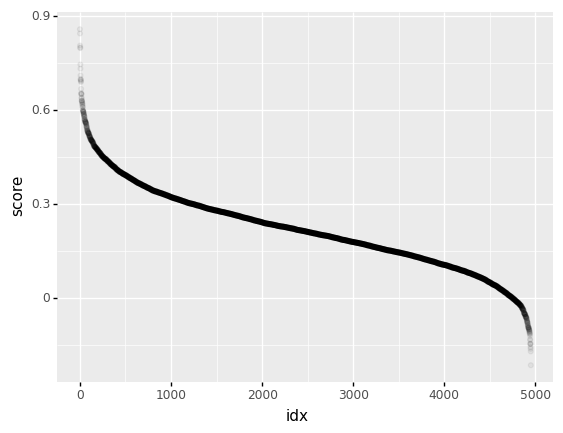

{<ggplot: (8791304985217)>}

In [25]:
from plotnine import *
{
    ggplot(comparisons, aes('idx','score'))
    + geom_point(alpha = .05)
}

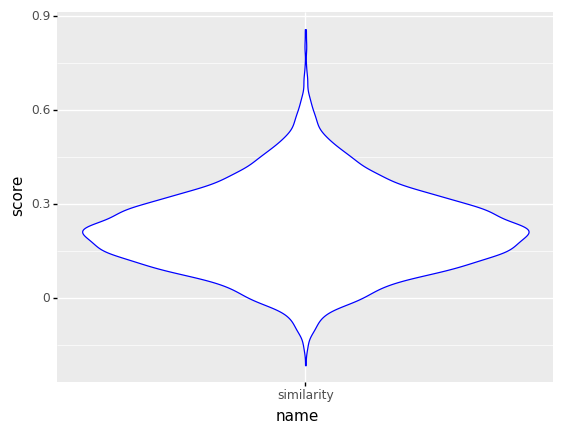

{<ggplot: (8792278184433)>}

In [26]:
{
    ggplot(comparisons, aes('name','score')) +
    geom_violin(color='blue')
}

## Listing 13.11

### Quickly matching vectors at query time

Now that we can get and compare concept embeddings, we need to be able to search these embeddings efficiently.

In [29]:
import nmslib
# initialize a new index, using a HNSW index on Cosine Similarity
index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(embeddings)
index.createIndex(print_progress=True)

# Example query for the new index.  The 25th embedding is the term 'bag'
ids, distances = index.knnQuery(embeddings[25], k=10)
matches = [sentences[idx] for idx in ids]
print(matches)

['Are there any cheap 1:25K electronic maps for the UK or Europe?', 'What attributes should I look for in an inexpensive multi-purpose folding bike?', 'Do folding cross country skis exist?', 'Free online UK maps', 'How to cross a 25 feet wide Crevasse?', 'Do polarized sunglasses protect against UV?', 'Why does the 528 thickness lines only appear on weather maps in the future?', 'Are folding poles suitable for cross-country skiing?', "What's a good, lightweight solution for portable cookware?", 'What exactly do the 2 knobs on my Zeiss 10 × 25B binoculars do?']


## Listing 13.12

In [65]:
from IPython.core.display import display,HTML
def print_labels(prefix,matches):
    display(HTML('<h4>Results for: <em>'+prefix+'</em></h4>'))
    for l,d in matches:
        print(str(int(d*1000)/1000),'|',l)
        
def semanticsearch(query,k=10):
    matches = []
    embeddings = stsb.encode([query], convert_to_tensor=True)
    ids, distances = index.knnQuery(embeddings[0], k=k)
    for i in range(len(ids)):
        text = sentences[ids[i]]
        dist = 1.0-distances[i]
        if dist>0.6:
            matches.append((text,dist))
    if not len(matches):
        matches.append((sentences[ids[1]],1.0-distances[1]))
    
    print_labels(query,matches)

In [66]:
semanticsearch('mountain hike')

0.725 | How is elevation gain and change measured for hiking trails?
0.706 | Hints for hiking the west highland way
0.698 | Fitness for hiking to Everest base camp
0.697 | Which altitude profile and height is optimal for Everesting by hiking?
0.678 | How to prepare on hiking routes?
0.678 | Long distance hiking trail markings in North America or parts thereof
0.675 | How far is a reasonable distance for someone to hike on their first trip?
0.668 | How to plan a day hike
0.666 | How do I Plan a Hiking Trip to Rocky Mountain National Park, CO
0.665 | Is there special etiquette for hiking the Appalachian Trail (AT) during AT Season
